In [1]:
import os
import json

from openml import tasks

from keywords import oml_task_ids

import matplotlib
import matplotlib.pyplot as plt

from pymoo.indicators.hv import HV
import numpy as np
import pandas as pd

matplotlib.style.use('seaborn-v0_8')

In [2]:
oml_tasks = tasks.get_tasks(oml_task_ids)
oml_datasets = [oml_task.get_dataset() for oml_task in oml_tasks]

oml_mapping = {  # to display dataset names with # of features on the plots as in original EAGGA paper
    oml_dataset.name: oml_dataset.get_data()[0].shape[1] - 1
    for oml_dataset in oml_datasets
}
oml_mapping

f:\workplace_github\ws2425-tab-ml\code\.venv\Lib\site-packages\openml\tasks\functions.py:372: UserWarning: `download_data` will default to False starting in 0.16. Please set `download_data` explicitly to suppress this warning.
  warnings.warn(
f:\workplace_github\ws2425-tab-ml\code\.venv\Lib\site-packages\openml\tasks\functions.py:380: UserWarning: `download_qualities` will default to False starting in 0.16. Please set `download_qualities` explicitly to suppress this warning.
  warnings.warn(


{'diabetes': 8,
 'spambase': 57,
 'pc3': 37,
 'jm1': 21,
 'kc2': 21,
 'pc1': 21,
 'banknote-authentication': 4,
 'wdbc': 30,
 'climate-model-simulation-crashes': 18,
 'blood-transfusion-service-center': 4,
 'gina': 970,
 'kc1': 21,
 'madeline': 259,
 'numerai28.6': 21,
 'ozone-level-8hr': 72,
 'philippine': 308,
 'phoneme': 5,
 'Satellite': 36,
 'sylvine': 20,
 'wilt': 5}

In [3]:
for i, path in enumerate(os.walk('export')):
    if i == 0:
        continue  # skip 'export' directory, only look at sub-directories
    print(path)

paths = list(os.walk('export'))[1:]
paths = sorted(paths, key=lambda path: oml_mapping[path[0].split('\\')[1]])  # order paths by # of features (ascending), as in original EAGGA paper

('export\\banknote-authentication', [], ['gen-0.json', 'gen-1.json', 'gen-10.json', 'gen-11.json', 'gen-12.json', 'gen-13.json', 'gen-14.json', 'gen-15.json', 'gen-16.json', 'gen-17.json', 'gen-18.json', 'gen-19.json', 'gen-2.json', 'gen-20.json', 'gen-21.json', 'gen-22.json', 'gen-23.json', 'gen-3.json', 'gen-4.json', 'gen-5.json', 'gen-6.json', 'gen-7.json', 'gen-8.json', 'gen-9.json', 'pareto.json'])
('export\\blood-transfusion-service-center', [], ['gen-0.json', 'gen-1.json', 'gen-10.json', 'gen-11.json', 'gen-12.json', 'gen-13.json', 'gen-14.json', 'gen-15.json', 'gen-16.json', 'gen-17.json', 'gen-18.json', 'gen-19.json', 'gen-2.json', 'gen-20.json', 'gen-21.json', 'gen-22.json', 'gen-23.json', 'gen-24.json', 'gen-25.json', 'gen-26.json', 'gen-27.json', 'gen-28.json', 'gen-29.json', 'gen-3.json', 'gen-30.json', 'gen-31.json', 'gen-32.json', 'gen-33.json', 'gen-34.json', 'gen-35.json', 'gen-36.json', 'gen-37.json', 'gen-38.json', 'gen-39.json', 'gen-4.json', 'gen-40.json', 'gen-41.

In [4]:
colours = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

nrows = 6
ncols = 3

## Plot (stop early set) losses of Pareto set

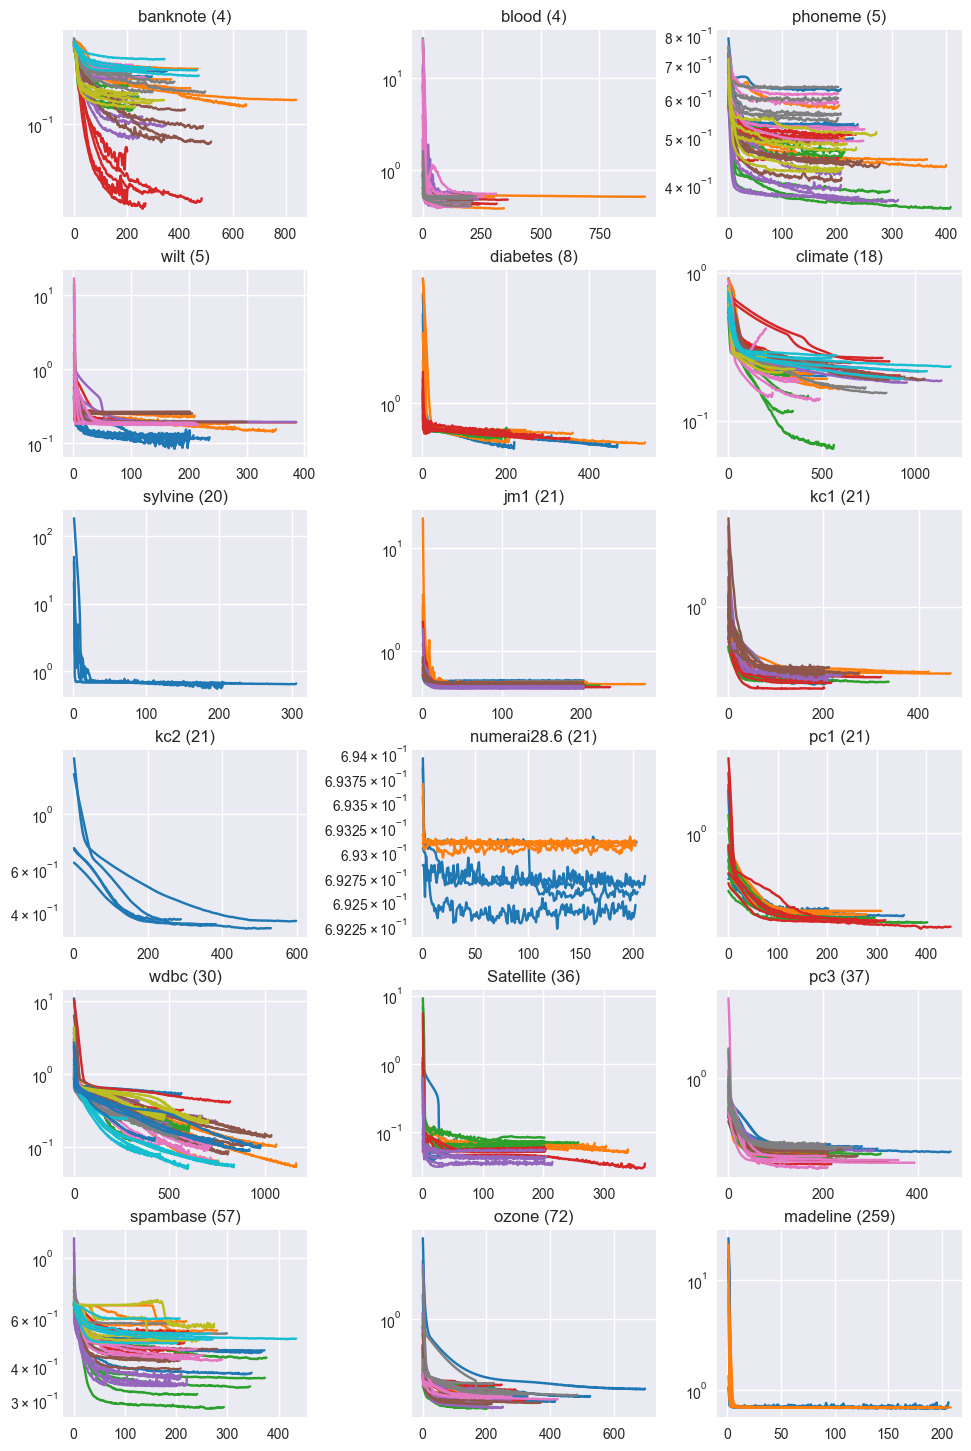

In [5]:
fig1, axs1 = plt.subplots(nrows=nrows, ncols=ncols)
for i, path in enumerate(paths):
    dataset_name = path[0].split('\\')[1]
    dataset_name = f'{dataset_name.split('-')[0]} ({oml_mapping[dataset_name]})'

    row = round(i // ncols)
    col = round(i % ncols)

    with open(os.path.join(path[0], 'pareto.json')) as f_pareto:
        pareto = json.load(f_pareto)

    for j, individual in enumerate(pareto['set']):
        losses = individual['metrics']['performance']['loss']

        for fold, loss_tuple in enumerate(losses):
            x = range(1, len(loss_tuple[1]) + 1)
            y = loss_tuple[1]

            axs1[row][col].plot(x, y, color=colours[j % len(colours)], label=f'Individual {j+1}')
    
    axs1[row][col].set_yscale('log')
    #axs1[row][col].set_xlabel('Epochs')
    #axs1[row][col].set_ylabel('Loss')
    #axs1[row][col].legend()
    axs1[row][col].set_title(dataset_name)

fig1.set_size_inches(6.4*ncols/2, 4.8*nrows/2)  # default is 6.4, 4.8, cf. https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.figure.html
fig1.set_layout_engine('compressed')
fig1.savefig('export/plot_early_stopping_losses_pareto_set.png', dpi=300)

## Plot (CV / val set) dominated hypervolumes of Pareto front

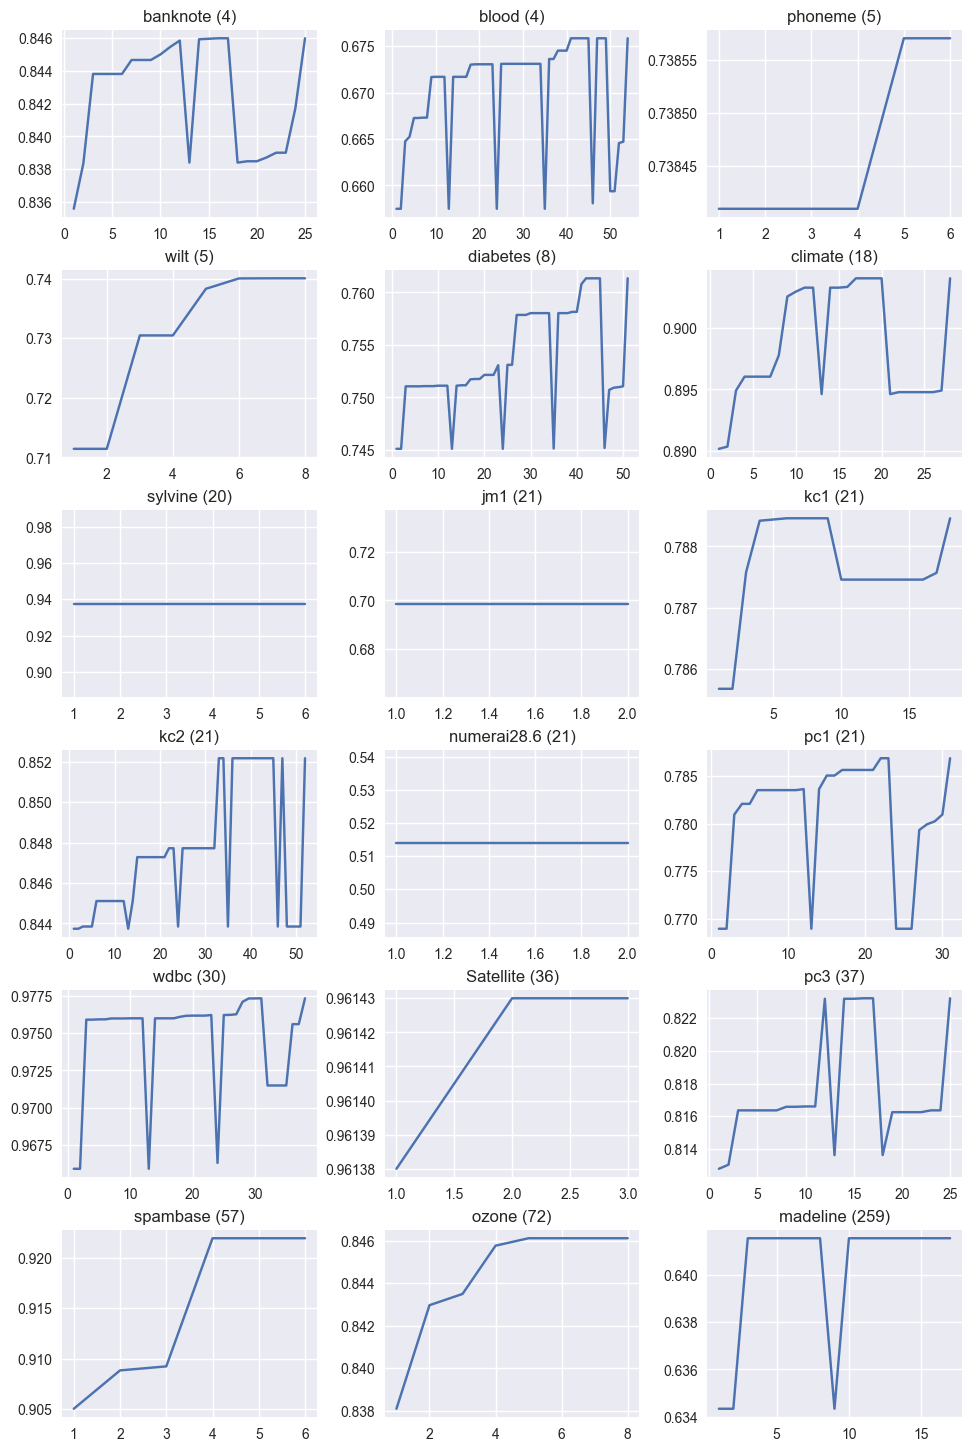

In [6]:
fig2, axs2 = plt.subplots(nrows=nrows, ncols=ncols)
for i, path in enumerate(paths):
    dataset_name = path[0].split('\\')[1]
    dataset_name = f'{dataset_name.split('-')[0]} ({oml_mapping[dataset_name]})'

    row = round(i // ncols)
    col = round(i % ncols)

    dhvs_val = list()
    for file_name in path[2]:
        with open(os.path.join(path[0], file_name)) as file:
            file_content = json.load(file)

        dhv_val = file_content['dhv_val']  # both gen-*.json and pareto.json files have this field
        dhvs_val.append(dhv_val)

    x = range(1, len(dhvs_val) + 1)
    axs2[row][col].plot(x, dhvs_val)
    #axs2[row][col].set_xlabel('Generations')
    #axs2[row][col].set_ylabel('Dominated Hypervolume')
    axs2[row][col].set_title(dataset_name)

fig2.set_size_inches(6.4*ncols/2, 4.8*nrows/2)  # default is 6.4, 4.8, cf. https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.figure.html
fig2.set_layout_engine('compressed')
fig2.savefig('export/plot_val_dhvs_over_time.png', dpi=300)

## Plot (test set) dominated hypervolumes of Pareto front of all datasets in one graph

In [13]:
# order paths same order as Figure 2 in original paper
paths_order = ['banknote', 'blood', 'wilt', 'phoneme', 'diabetes', 'climate', 'sylvine', 'jm1', 'kc2', 'pc1', 'numerai28.6', 'kc1', 'wdbc', 'Satellite', 'pc3', 'spambase', 'ozone', 'madeline', 'philippine', 'gina']
paths = sorted(paths, key=lambda path: paths_order.index(path[0].split('\\')[1].split('-')[0]))

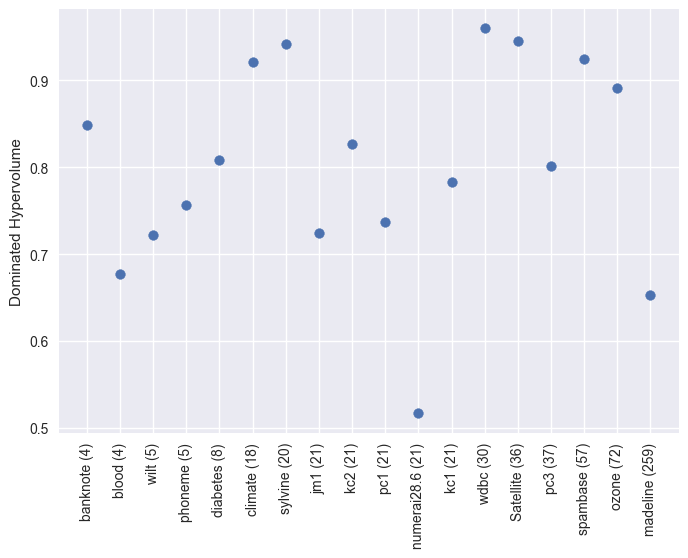

In [14]:
fig3, ax3 = plt.subplots()

dhvs_test = list()
dataset_names = list()
for i, path in enumerate(paths):
    dataset_name = path[0].split('\\')[1]
    dataset_name = f'{dataset_name.split('-')[0]} ({oml_mapping[dataset_name]})'

    with open(os.path.join(path[0], 'pareto.json')) as f_pareto:
        pareto = json.load(f_pareto)

    dhvs_test.append(pareto['dhv_test'])
    dataset_names.append(dataset_name)

ax3.scatter(dataset_names, dhvs_test, label='Dominated Hypervolume')

ax3.tick_params(axis='x', labelrotation=90)
ax3.set_ylabel('Dominated Hypervolume')

fig3.savefig('export/plot_test_dhvs.png', dpi=300, bbox_inches='tight')  # otherwise legend is cut off, cf. https://stackoverflow.com/a/42303455

## Get Pareto set + front for each dataset and hypervolume contribution for each individual in the Pareto set

In [15]:
hv_obj = HV(ref_point=(1, 1, 1, 1), nds=False)

dataset_dfs = dict()
for i, path in enumerate(paths):
    dataset_name = path[0].split('\\')[1]
    dataset_name = f'{dataset_name.split('-')[0]} ({oml_mapping[dataset_name]})'

    with open(os.path.join(path[0], 'pareto.json')) as f_pareto:
        pareto = json.load(f_pareto)

    pareto_set = pareto['set']
    for individual in pareto_set:
        del individual['rank_nds']
        del individual['cd']
        del individual['metrics']['performance']['loss']
        del individual['group_structure']['all_features']
        del individual['group_structure']['feature_signs']
    pareto_set += [None]  # add dummy entry corresponding to featureless learner

    pareto_front = pareto['front_test']
    pareto_front_nds = [(1 - metrics[0], *metrics[1:]) for metrics in pareto_front]

    dhv_contributions = list()
    for i in range(len(pareto_front_nds)):
        dhv_contribution = pareto['dhv_test'] - hv_obj(np.array(pareto_front_nds[:i] + pareto_front_nds[i+1:])).item()
        dhv_contributions.append(round(dhv_contribution, 5))

    rows = list()
    for individual, metrics, hv_contribution in zip(pareto_set, pareto_front, dhv_contributions):
        rows.append((
            individual['total_layers'] if individual is not None else None,
            individual['nodes_per_hidden_layer'] if individual is not None else None,
            individual['p_dropout'] if individual is not None else None,
            individual['group_structure']['excluded'] if individual is not None else None,
            individual['group_structure']['included'] if individual is not None else None,
            metrics[0],
            metrics[1],
            metrics[2],
            metrics[3],
            hv_contribution
        ))

    dataset_dfs[dataset_name] = pd.DataFrame(
        data=rows,
        columns=['total layers', 'nodes per hidden layer', 'p dropout', 'excluded', 'included', 'auc', 'nf', 'ni', 'nnm', 'dhv contribution']
    )

In [16]:
for dataset_name, dataset_df in dataset_dfs.items():
    print(dataset_name)
    print(dataset_df)
    dataset_df.to_csv(f'export/{dataset_name}.csv', index=False)

banknote (4)
    total layers  nodes per hidden layer  p dropout   excluded  \
0            3.0                     6.0        0.3  [1, 2, 3]   
1            3.0                     4.0        0.0     [2, 3]   
2            5.0                     9.0        0.1     [3, 2]   
3            3.0                     6.0        0.1        [3]   
4            4.0                     8.0        0.1        [3]   
5            3.0                     5.0        0.1        [3]   
6            3.0                     8.0        0.3     [3, 1]   
7            3.0                     8.0        0.5        [3]   
8            4.0                    11.0        0.1     [3, 2]   
9            3.0                     4.0        0.1  [1, 2, 3]   
10           NaN                     NaN        NaN       None   

                   included      auc    nf       ni   nnm  dhv contribution  
0                [[[0], 0]]  0.93027  0.25  0.00000  0.25           0.00105  
1             [[[0, 1], 1]]  0.96225  